# DeepOF unsupervised pipeline: exploring the behavioral space

In [10]:
import pickle
import numpy as np
with open("../train_models/deepof_unsupervised_VQVAE_encodings_input=coords_k=100_latdim=8_kmeans_loss=0.0_run=1.pkl", "rb") as handle:
    vqvae_solution = pickle.load(handle)

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deepof.post_hoc import get_transitions
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm_notebook as tqdm


def merge_and_smooth_clusters(
    n_clusters, centroids, embedding, concat_embedding, cluster_assignments
):
    """Merges the current clusters using a hierarchical agglomerative approach, and smoothens using a Gaussian HMM.

    Args:
        n_clusters (int): number of clusters to report.
        centroids (np.ndarray): precomputed means per cluster.
        embedding (tabdict): original deepof.TableDict object containing unsupervised embeddings.
        concat_embedding (np.ndarray): concatenated list of embeddings per animal in the dataset.
        cluster_assignments (tabdict): original deepof.TableDict object containing cluster assignments.

    Returns:
        new_soft_assignments (np.ndarray): concatenated postprocessed assignments for all animals in the dataset.
    """

    # Merge clusters ussing a hierarchical agglomerative approach
    new_hard_assignments = AgglomerativeClustering(
        n_clusters=n_clusters, compute_distances=True
    ).fit_predict(centroids)
    cluster_predictor = LinearDiscriminantAnalysis().fit(
        centroids, new_hard_assignments
    )
    centroids = cluster_predictor.means_
    new_soft_assignments = cluster_predictor.predict_proba(concat_embedding)

    # Rebuild the soft assignments dictionary per experimental animal
    new_soft_assignments = np.split(
        new_soft_assignments,
        np.cumsum([i.shape[0] for i in embedding.values()]),
    )
    new_soft_assignments = {
        key: val for key, val in zip(cluster_assignments.keys(), new_soft_assignments)
    }

    # Smooth assignments across time using a Gaussian HMM on the embeddings, with priors based on the clustering results
    for key, val in tqdm(new_soft_assignments.items()):

        hmm = GaussianHMM(
            startprob_prior=np.unique(val.argmax(axis=1), return_counts=True)[1],
            transmat_prior=get_transitions(val.argmax(axis=1), n_states=n_clusters) + 10,
            means_prior=centroids,
            n_components=n_clusters,
            covariance_type="diag",
            n_iter=100,
            tol=0.0001,
        )
        
        hmm.fit(embedding[key].numpy())
        new_soft_assignments[key] = hmm.predict_proba(embedding[key].numpy())

    return new_soft_assignments


def cluster_postprocessing(embedding, cluster_assignments, n_clusters="auto"):
    """Merges clusters using a hierarchical approach.

    Args:
        embedding (list): list of embeddings per animal in the dataset.
        cluster_assignments (list): list of cluster assignments per animal in the dataset.
        n_clusters (int): number of clusters to report.

    Returns:
        new_soft_assignments (list): list of new (merged) cluster assignments.

    """
    # Concatenate embeddings and cluster assignments in to unique np.ndarray objects
    concat_embedding = np.concatenate([tensor.numpy() for tensor in embedding.values()])
    hard_assignments = np.concatenate(
        [tensor.numpy().argmax(axis=1) for tensor in cluster_assignments.values()]
    )

    assert concat_embedding.shape[0] == hard_assignments.shape[0]

    # Get cluster centroids from the concatenated embeddings
    centroids = []
    for cluster in range(np.max(hard_assignments)):
        centroid = concat_embedding[hard_assignments == cluster]
        if len(centroid) == 0:
            continue
        centroid = np.mean(centroid, axis=0)
        centroids.append(centroid)

    centroids = np.stack(centroids)

    # Merge centroids using a hierarchical approach with the given resolution, and soft-assign instances to clusters
    if isinstance(n_clusters, int):
        new_soft_assignments = merge_and_smooth_clusters(
            n_clusters, centroids, embedding, concat_embedding, cluster_assignments
        )

    else:
        raise NotImplementedError

    return new_soft_assignments

In [12]:
# from hmmlearn.hmm import GaussianHMM

# new_ass = cluster_postprocessing(
#     vqvae_solution[0], 
#     vqvae_solution[1],
#     n_clusters=12
# )
# hcc = new_ass['20191203_Day1_SI_JB08_Test_54'].argmax(axis=1)

In [13]:
# import umap

# # Cluster on the original embedding space
# new_emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'])

# sns.scatterplot(x=new_emb[:, 0], y=new_emb[:, 1], hue=hcc, palette="tab20")

# plt.show()

In [14]:
# # How prevalent are these clusters?
# from collections import Counter
# print(Counter(hcc))

# new_ass = hcc

In [15]:
# # How often does the model change clusters?
# from collections import defaultdict

# lengths = defaultdict(list)
# cur = 0
# for i in range(1, len(new_ass)):
#     if new_ass[i-1] == new_ass[i]:
#         cur += 1
#     else:
#         lengths[new_ass[i-1]].append(cur)
#         cur = 1

# {key:np.mean(val) for key, val in lengths.items()}

In [16]:
# import pandas as pd

# # Duration histograms per cluster
# lengths_df = pd.DataFrame([lengths]).melt().explode("value").astype(int)
# sns.violinplot(data=lengths_df, x="variable", y="value")

# plt.axhline(25, linestyle="--", color="black")
        
# plt.show()

In [17]:
# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
# ss = my_deepof_project.get_coords(speed=1)

# tt = cc.merge(ss)

tt = tt.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    handle_ids="split", # "concat" uses bps from != animals as features, "split"
)

In [18]:
tt = (tt[0][:25000], tt[1][:25000], tt[2][:25000], tt[3][:25000])

In [117]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    tt,
    embedding_model="VaDE",
    epochs=10,
    encoder_type="recurrent",
    n_components=15,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=128,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
)

2022-12-11 17:33:00.700360: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-11 17:33:00.700372: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-11 17:33:00.700500: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Epoch 1/10


2022-12-11 17:33:08.892874: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 20s 22ms/step - total_loss: 28.8327 - reconstruction_loss: 27.2836 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0497 - kl_divergence: -5.4097 - kmeans_loss: 1.6238 - number_of_populated_clusters: 13.3128 - confidence_in_selected_cluster: 0.5511
Epoch 2/10
195/195 [==============================] - 4s 21ms/step - total_loss: 25.4301 - reconstruction_loss: 24.5142 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.1497 - kl_divergence: -4.4439 - kmeans_loss: 1.5558 - number_of_populated_clusters: 12.8154 - confidence_in_selected_cluster: 0.5392
Epoch 3/10
195/195 [==============================] - 4s 21ms/step - total_loss: 24.2467 - reconstruction_loss: 23.7356 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2497 - kl_divergence: -4.3022 - kmeans_loss: 1.5734 - number_of_populated_clusters: 12.5641 - confidence_in_selected_cluster: 0.5438
Epoch 4/10
195/195 [=====================

2022-12-11 17:33:41.712854: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 4s 21ms/step - total_loss: 22.9114 - reconstruction_loss: 23.3929 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.4497 - kl_divergence: -4.9639 - kmeans_loss: 1.6762 - number_of_populated_clusters: 12.8923 - confidence_in_selected_cluster: 0.5728
Epoch 6/10
195/195 [==============================] - 4s 22ms/step - total_loss: 22.1916 - reconstruction_loss: 23.3782 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.5497 - kl_divergence: -5.9252 - kmeans_loss: 1.8372 - number_of_populated_clusters: 12.9333 - confidence_in_selected_cluster: 0.6144
Epoch 7/10
195/195 [==============================] - 4s 21ms/step - total_loss: 21.3419 - reconstruction_loss: 23.3579 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.6497 - kl_divergence: -6.9539 - kmeans_loss: 2.0290 - number_of_populated_clusters: 12.8410 - confidence_in_selected_cluster: 0.6675
Epoch 8/10
195/195 [======================

2022-12-11 17:34:15.161938: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-11 17:34:15.161959: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  7/195 [>.............................] - ETA: 4:24 - total_loss: 29.9104 - reconstruction_loss: 23.5265 - clustering_loss: -0.9574 - prior_loss: 2.7080 - kl_weight: 0.0015 - kl_divergence: -10.1298 - kmeans_loss: 2.7894 - number_of_populated_clusters: 9.0000 - confidence_in_selected_cluster: 0.9709    

2022-12-11 17:34:23.459920: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-11 17:34:23.464937: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-11 17:34:23.469866: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20221211-173300/plugins/profile/2022_12_11_17_34_23

2022-12-11 17:34:23.471445: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20221211-173300/plugins/profile/2022_12_11_17_34_23/MC-C9791E.local.trace.json.gz
2022-12-11 17:34:23.476484: I tensorflow/core/profiler

195/195 [==============================] - ETA: 0s - total_loss: 27.4047 - reconstruction_loss: 23.0871 - clustering_loss: -0.9445 - prior_loss: 2.7080 - kl_weight: 0.0497 - kl_divergence: -7.3697 - kmeans_loss: 2.2607 - number_of_populated_clusters: 9.8308 - confidence_in_selected_cluster: 0.9614

2022-12-11 17:34:27.690855: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 25s 96ms/step - total_loss: 27.4047 - reconstruction_loss: 23.0871 - clustering_loss: -0.9445 - prior_loss: 2.7080 - kl_weight: 0.0497 - kl_divergence: -7.3697 - kmeans_loss: 2.2607 - number_of_populated_clusters: 9.8308 - confidence_in_selected_cluster: 0.9614 - val_total_loss: 25.7395 - val_reconstruction_loss: 23.3729 - val_clustering_loss: -0.9126 - val_prior_loss: 2.7080 - val_kl_weight: 0.1000 - val_kl_divergence: -6.0792 - val_kmeans_loss: 0.9712 - val_number_of_populated_clusters: 6.3282 - val_confidence_in_selected_cluster: 0.9394 - lr: 0.0010
Epoch 2/10
195/195 [==============================] - 6s 29ms/step - total_loss: 25.9260 - reconstruction_loss: 23.0625 - clustering_loss: -0.9352 - prior_loss: 2.7080 - kl_weight: 0.1497 - kl_divergence: -5.6034 - kmeans_loss: 1.7936 - number_of_populated_clusters: 10.0923 - confidence_in_selected_cluster: 0.9549 - val_total_loss: 24.9668 - val_reconstruction_loss: 23.3322 - val_clustering_loss

2022-12-11 17:35:01.401480: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 6s 30ms/step - total_loss: 23.3952 - reconstruction_loss: 22.9809 - clustering_loss: -0.9448 - prior_loss: 2.7080 - kl_weight: 0.5497 - kl_divergence: -6.6365 - kmeans_loss: 1.9693 - number_of_populated_clusters: 9.5692 - confidence_in_selected_cluster: 0.9614 - val_total_loss: 21.9049 - val_reconstruction_loss: 22.9984 - val_clustering_loss: -0.9283 - val_prior_loss: 2.7080 - val_kl_weight: 0.6000 - val_kl_divergence: -7.0530 - val_kmeans_loss: 0.9169 - val_number_of_populated_clusters: 6.3179 - val_confidence_in_selected_cluster: 0.9500 - lr: 0.0010
Epoch 7/10
195/195 [==============================] - 6s 30ms/step - total_loss: 22.6388 - reconstruction_loss: 22.9962 - clustering_loss: -0.9492 - prior_loss: 2.7080 - kl_weight: 0.6497 - kl_divergence: -7.4563 - kmeans_loss: 2.1517 - number_of_populated_clusters: 9.3436 - confidence_in_selected_cluster: 0.9645 - val_total_loss: 20.9827 - val_reconstruction_loss: 23.0119 - val_clustering_loss: 

In [118]:
emb = cons.encoder(tt[0][:25000])
cls = cons.grouper(tt[0][:25000])

In [119]:
import umap
umap = umap.UMAP(n_components=2, n_neighbors=250).fit_transform(emb.numpy())
# umap = emb.numpy()

In [120]:
from collections import Counter

Counter(cls.numpy().argmax(axis=1))

Counter({11: 2827,
         4: 1437,
         0: 1951,
         9: 1979,
         12: 1054,
         5: 617,
         10: 1019,
         1: 1252,
         7: 2409,
         13: 2513,
         6: 1102,
         3: 2174,
         14: 2226,
         8: 1174,
         2: 1266})

In [121]:
cons.get_gmm_params

{'means': <tf.Variable 'mu_c:0' shape=(15, 8) dtype=float32, numpy=
 array([[ 0.11007503,  2.1508791 , -3.16687   , -0.15838212, -1.8408326 ,
          0.76714104,  2.692896  , -1.3960328 ],
        [-1.5995493 , -1.3923985 ,  1.5019091 ,  2.4740405 ,  4.129927  ,
         -0.10368171, -1.1900806 ,  1.4080551 ],
        [ 4.101694  , -1.7669833 ,  3.915112  , -2.860989  , -4.9210134 ,
         -2.0230956 , -1.8781807 ,  1.259809  ],
        [-0.8276908 ,  0.16146535, -0.9425248 , -1.4678409 ,  0.02809527,
          1.2482169 , -0.52651864, -0.17018771],
        [-0.9160395 ,  1.2239021 , -2.3595705 , -0.16900223,  0.13644803,
          1.1062422 ,  1.1711164 , -0.8983232 ],
        [-1.566999  ,  0.7970169 , -1.7305707 ,  1.7670683 ,  2.4058523 ,
          0.8156325 ,  1.1523386 , -0.3386912 ],
        [ 4.050518  , -3.3904681 ,  6.7599134 ,  0.6652774 , -1.7463342 ,
         -3.520138  , -2.5106504 ,  2.8773005 ],
        [-1.4236188 ,  0.3937355 , -0.76067305,  4.9407196 ,  3.5608118

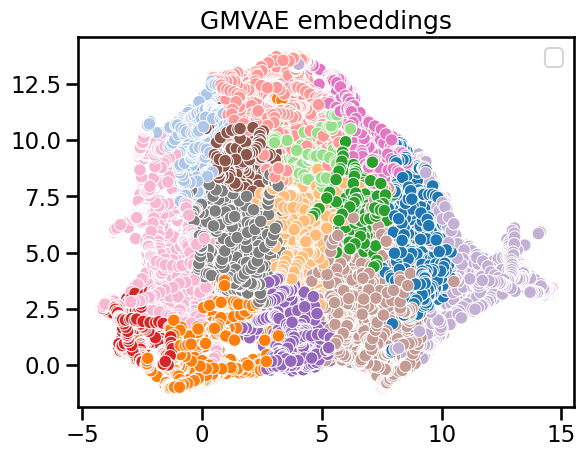

In [122]:
#tt = GaussianMixture(n_components=5, covariance_type="diag", reg_covar=1e-04).fit(emb.numpy())
#means = tt.means_
means = cons.get_gmm_params['means'].numpy()

sns.scatterplot(x=umap[:, 0], y=umap[:, 1], hue=cls.numpy().argmax(axis=1), palette="tab20")
means = cons.get_layer("grouper").get_layer("gaussian_mixture_latent").c_mu.numpy()
#sns.scatterplot(x=means[:,0], y=means[:,1], s=250, c="black")

plt.title("GMVAE embeddings")

plt.legend("")
plt.show()

In [ ]:
cons.get_gmm_params['weights'].numpy().sum()

In [ ]:
tt = np.split(np.concatenate(tt), np.cumsum([i.shape[0] for k,i in vqvae_solution[0].items() if k in list(cc.keys())]))

for i in tt:
    print(i.shape)
    print(np.max(np.abs(i.mean(axis=0))))
    print(np.mean(np.abs(i.std(axis=0))))
